#Median House Value with one-hidden layer neural networks (Classification)

Runtime type has been set to TPU

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Instructions for updating:
non-resource variables are not supported in the long term


Mounted at /gdrive


In [2]:
# Modify the paths accordingly to point the csv files in your own gdrive file system.
ATT_FILE = "/gdrive/My Drive/MedianHouseValuePreparedCleanAttributes.csv"
LABEL_FILE = "/gdrive/My Drive/MedianHouseValueOneHotEncodedClasses.csv"

TRAIN_RATE=0.8 # 80% of the entire dataset is for training purposes

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2)
#n_final_test = n_instances-n_train-n_dev

x_train = attributes.values[:n_train]
t_train = label.values[:n_train]

x_dev = attributes.values[n_train:n_train+n_dev]
t_dev = label.values[n_train:n_train+n_dev]

print ("x_train:",x_train.shape)
print ("t_train:",t_train.shape)

print ("x_dev:",x_dev.shape)
print ("t_dev:",t_dev.shape)

# We can not employ the final test set yet, since this is not the final neural approach

x_train: (16342, 9)
t_train: (16342, 3)
x_dev: (2043, 9)
t_dev: (2043, 3)


## Initialization

In [8]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1))

Some data is displayed to test correctness:

In [9]:
x_train[:5]

array([[ 0.21713147, -0.69394261,  0.41176471, -0.93926446, -0.88733706,
        -0.90924634, -0.89278079, -0.77585137, -1.        ],
       [-0.69322709,  0.17747078, -0.29411765, -0.91795107, -0.88671633,
        -0.95448303, -0.88949186, -0.59159184,  1.        ],
       [ 0.44820717, -0.95961743,  0.37254902, -0.8306628 , -0.80074488,
        -0.89349477, -0.79575728, -0.5589716 ,  1.        ],
       [ 0.29083665, -0.7088204 , -0.41176471, -0.87629076, -0.85909373,
        -0.94315984, -0.84377569, -0.48705535, -1.        ],
       [-0.40039841,  0.15834219, -0.49019608, -0.8418536 , -0.84574798,
        -0.93413493, -0.82765992, -0.16468738, -0.33333333]])

In [10]:
t_train[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [11]:
x_dev[:5]

array([[ 0.22908367, -0.67906482,  0.45098039, -0.83366397, -0.77343265,
        -0.81524146, -0.76155238, -0.67868029, -1.        ],
       [-0.61752988,  0.10308183,  1.        , -0.94201129, -0.93078833,
        -0.97247681, -0.93257688, -0.37100178,  0.33333333],
       [-0.39043825,  0.16046759, -0.88235294, -0.92929447, -0.90037244,
        -0.90016536, -0.89870087, -0.74136908, -0.33333333],
       [-0.24701195, -0.45377258, -0.33333333, -0.85156926, -0.82774674,
        -0.94030102, -0.81877981, -0.58286093, -1.        ],
       [ 0.22908367, -0.73645058, -0.25490196, -0.90589552, -0.82774674,
        -0.90420135, -0.81746423, -0.86805699,  1.        ]])

In [12]:
t_dev[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

## Hyperparameters

The learning rate $\alpha$, the batch size, and the number of neurons in the hidden layer are the three hyperparameters to adjust. The learning process stops when it reaches 20,000 learning iterations. An iteration comprises presenting the network *batch_size* learning examples and then adjusting the weights (parameters).

In [13]:
n_iterations = 10000
learning_rate = 0.185
batch_size = 140
n_hidden = 180

## Build the model: a full-connected 9-1000-3 neural network architecture

In [14]:
X = tf.placeholder (dtype=tf.float32, shape=(None,INPUTS),name="X")
t = tf.placeholder (dtype=tf.float32, shape=(None,OUTPUTS), name="t")

In [15]:
W1 = tf.Variable (tf.random_uniform ([INPUTS,n_hidden],-1,1), name="W1")
b1 = tf.Variable (tf.zeros([n_hidden]), name = "bias1")
W2 = tf.Variable (tf.random_uniform ([n_hidden,OUTPUTS],-1,1), name="W2")
b2 = tf.Variable (tf.zeros([OUTPUTS]), name = "bias2")

A classical multilayer perceptron is defined: X is the input vector with 9 components, 1,000 neurons in the hidden layer with **tanh activation function**, and 3 outputs with the softmax activation function.

In [16]:
hidden = tf.nn.tanh(tf.add(tf.matmul(X,W1),b1), name="hidden")
net_out = tf.add (tf.matmul(hidden,W2),b2, name="net_out")
y = tf.nn.softmax (logits=net_out, name="y")

The $log-loss$, $cross-entropy$ (the sun of log-loss is a loss) and and $cost$ (the mean of cross-entropy) functions:

In [17]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2 (labels=t, logits=net_out)
mean_log_loss = tf.reduce_mean (cross_entropy, name="cost")

The training algorithm: gradient descent method:

In [18]:
train_step = tf.train.GradientDescentOptimizer (learning_rate).minimize(mean_log_loss)

Model evaluation: accuracy. The percentage of correctly classified instances.

In [19]:
correct_predictions = tf.equal(tf.argmax(y,1),tf.argmax(t,1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

## Execute the model MBGD
Since the batch size is 500 and the number of examples is 16,342, there are 33 iterations per epoch. Therefore 20,000 iterations are equivalent to about 600 epochs.  

In [20]:
init = tf.global_variables_initializer()
accuracy_train_history = []
with tf.Session() as sess:
    sess.run(init)
    for iteration in tqdm(range(n_iterations)):
        offset = (iteration * batch_size) % (NUM_TRAINING_EXAMPLES - batch_size)
        sess.run (train_step, feed_dict={X: x_train[offset:(offset+batch_size)],
                                         t: t_train[offset:(offset+batch_size)]})
        accuracy_train_history.append (accuracy.eval(feed_dict=
                                {X: x_train[offset:(offset+batch_size)],
                                 t: t_train[offset:(offset+batch_size)]}))
    accuracy_train = accuracy.eval(feed_dict={X: x_train[:NUM_TRAINING_EXAMPLES],
                                              t: t_train[:NUM_TRAINING_EXAMPLES]})
    accuracy_dev = accuracy.eval(feed_dict={X: x_dev[:NUM_DEV_EXAMPLES],
                                              t: t_dev[:NUM_DEV_EXAMPLES]})
    predictions = y.eval(feed_dict={X: x_dev[:NUM_DEV_EXAMPLES]})
    final_correct_preditions = correct_predictions.eval (feed_dict=
                                    {X: x_dev[:NUM_DEV_EXAMPLES],
                                     t: t_dev[:NUM_DEV_EXAMPLES]})
    final_train_mean_log_loss = mean_log_loss.eval (feed_dict=
                                            {X: x_train[:NUM_TRAINING_EXAMPLES],
                                              t: t_train[:NUM_TRAINING_EXAMPLES]})
    final_dev_mean_log_loss = mean_log_loss.eval (feed_dict=
                                            {X: x_dev[:NUM_DEV_EXAMPLES],
                                              t: t_dev[:NUM_DEV_EXAMPLES]})

100%|██████████| 10000/10000 [00:28<00:00, 346.93it/s]


In [21]:
"Accuracy in training: " + str(accuracy_train)

'Accuracy in training: 0.7530902'

In [22]:
"Accuracy for the development test set: " + str(accuracy_dev)

'Accuracy for the development test set: 0.7537934'

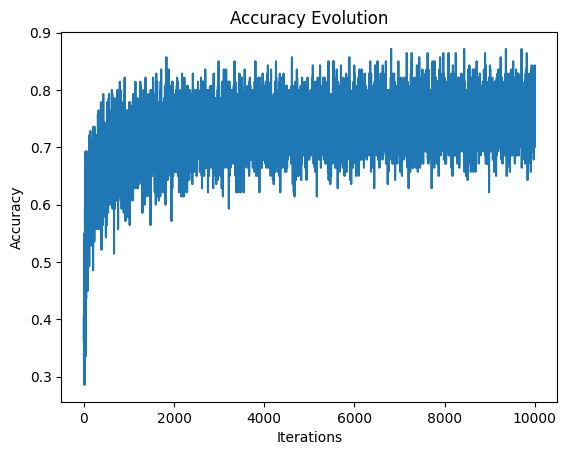

In [23]:
plt.title ("Accuracy Evolution")
plt.xlabel ("Iterations")
plt.ylabel ("Accuracy")
plt.plot (range(n_iterations),accuracy_train_history)

Note that accuracy $zig$-$zags$ due to mini-batch $zig$-$zagging$ errors, yet the trend is positive.  

In [24]:
predictions

array([[2.9079127e-01, 6.6499752e-01, 4.4211186e-02],
       [7.3112734e-04, 4.9755231e-02, 9.4951355e-01],
       [6.7839432e-01, 3.1675053e-01, 4.8551108e-03],
       ...,
       [1.1153268e-08, 2.9400201e-04, 9.9970597e-01],
       [8.4371194e-02, 5.3958422e-01, 3.7604454e-01],
       [9.3946344e-01, 5.7095267e-02, 3.4413252e-03]], dtype=float32)

In [25]:
rounded_predictions=np.round(predictions)
indices = np.argmax(predictions,1)
for row, index in zip(rounded_predictions, indices): row[index]=1
rounded_predictions[:20]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [26]:
t_dev[:20]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [27]:
final_correct_preditions[:20]

array([False,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True, False,  True, False,  True,  True,  True,  True,
        True,  True])

In [28]:
from collections import Counter
Counter (final_correct_preditions)

Counter({False: 503, True: 1540})

In [29]:
final_train_mean_log_loss

0.5676727

In [30]:
final_dev_mean_log_loss

0.55939674

**Train accuracy is now 76% and dev accuracy has raised to 75%**.  This means that the neural model is not overfitted. Time spent is about 2:30 minutes. Mini-batch gradient descent has been applied. Back propagation makes intensive vectorial computation. TPU has been employed.